# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

la principale différence entre les modèles de langage basés sur les mots et les modèles de langage basés sur les caractères réside dans l'unité de base qu'ils utilisent pour la prédiction : les mots pour les premiers et les caractères pour les seconds. Le choix entre les deux dépend du domaine d'application et des exigences spécifiques de la tâche que vous souhaitez accomplir.


## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

Import pandas and load the first 1000 lines

In [1]:
import pandas as pd

dataset_path = "250k_smiles.csv"
df = pd.read_csv(dataset_path, nrows=1000)

Display the first rows of the dataframe

In [2]:
print(df.head())

                                              smiles     logP       qed  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n  5.05060  0.702012   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS  
0  2.084095  
1  3.432004  
2  2.470633  
3  2.822753  
4  4.035182  


## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [3]:
df['smiles_length'] = df['smiles'].apply(len)
max_smiles_length = df['smiles_length'].max()
index_of_max_smiles = df['smiles_length'].idxmax()

print(max_smiles_length)
print(df.loc[index_of_max_smiles])

106
smiles           C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C...
logP                                                        0.6261
qed                                                       0.465834
SAS                                                       5.692541
smiles_length                                                  106
Name: 467, dtype: object



Code a function **unic_characters(string)** which return the unic characters in a string


In [4]:
def unic_characters(string):
    unique_chars = set()

    for char in string:
        unique_chars.add(char)

    unique_chars_list = sorted(list(unique_chars))

    unique_chars_string = ''.join(unique_chars_list)

    return unique_chars_string

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [5]:
concatenated_smiles = ''.join(df['smiles'])

unique_chars = unic_characters(concatenated_smiles)

print("Unique characters in concatenated SMILES:", unique_chars)


Unique characters in concatenated SMILES: 
#()+-/1234567=@BCFHINOS[\]clnors


Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [6]:
def map_char_to_int(unic_chars):
    char_to_int = {char: idx for idx, char in enumerate(unic_chars)}

    end_char = "\n"  
    char_to_int[end_char] = len(unic_chars)

    return char_to_int
  
char_mapping = map_char_to_int(unique_chars)

print(char_mapping)

{'\n': 33, '#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '=': 14, '@': 15, 'B': 16, 'C': 17, 'F': 18, 'H': 19, 'I': 20, 'N': 21, 'O': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, 'c': 27, 'l': 28, 'n': 29, 'o': 30, 'r': 31, 's': 32}


Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [7]:
class CharMapper:
    def __init__(self, unic_chars, end_char="\n"):
        self.char_to_int = {char: idx for idx, char in enumerate(unic_chars)}
        self.int_to_char = {idx: char for char, idx in self.char_to_int.items()}
        
        self.end_char = end_char
        end_char_idx = len(unic_chars)
        self.char_to_int[end_char] = end_char_idx
        self.int_to_char[end_char_idx] = end_char

    def map_char_to_int(self, char):
        if char in self.char_to_int:
            return self.char_to_int[char]
        else:
            return self.char_to_int[self.end_char]  # Retourner l'indice du caractère de fin par défaut

    def map_int_to_char(self, integer):
        return self.int_to_char[integer]


For each smile molecule add the ending token to it

In [8]:
ending_token = "\n"
df['SMILES_with_end_token'] = df['smiles'].apply(lambda x: x + ending_token)

print(df[['smiles', 'SMILES_with_end_token']].head())

                                              smiles  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...   

                               SMILES_with_end_token  
0        CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n\n  
1   C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n\n  
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  


## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

n_features dans ce contexte serait le nombre total de caractères uniques (comprenant le caractère de fin ajouté) dans l'ensemble des données SMILES

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

In [9]:
def build_X_and_y(string, i_char, seq_length):
    if i_char + seq_length >= len(string) or i_char < 0:
        raise ValueError("Invalid position i_char or seq_length")

    X = string[i_char : i_char + seq_length]

    y = string[i_char + seq_length]

    return X, y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [10]:
input_string = "abcdefghijklmnopqrstuvwxyz"

# Specify the sequence length
sequence_length = 4

# Specify the positions 'i' where we want to extract X and y
positions = [1, 2, 3]

# Test the function for each position
for i in positions:
    X, y = build_X_and_y(input_string, i, sequence_length)
    print(f"At position {i}:")
    print("Input sequence (X):", X)
    print("Output label (y):", y)
    print() 

At position 1:
Input sequence (X): bcde
Output label (y): f

At position 2:
Input sequence (X): cdef
Output label (y): g

At position 3:
Input sequence (X): defg
Output label (y): h



By using build_X_and_y and map_char_to_int build a list named X_train and a list named y_train

In [11]:
seq_length = 10  

char_mapper = CharMapper(unique_chars)  

X_train = []
y_train = []

for index, row in df.iterrows():
    smiles_sequence = row['SMILES_with_end_token']  

    # Create X and y pairs using the build_X_and_y function
    for i in range(len(smiles_sequence) - seq_length):
        X_sequence, y_label = build_X_and_y(smiles_sequence, i, seq_length)

        # Map characters to integers using the CharMapper instance
        X_sequence_int = [char_mapper.map_char_to_int(char) for char in X_sequence]
        y_label_int = char_mapper.map_char_to_int(y_label)

        # Append the integer sequences to X_train and y_train
        X_train.append(X_sequence_int)
        y_train.append(y_label_int)

# X_train and y_train now contain the training data as lists of integer sequences
# You can convert them to numpy arrays if needed


Create numpy arrays from the lists

In [12]:
import numpy as np


X_train = np.array(X_train)
y_train = np.array(y_train)

Reshape the X numpy array (n_examples, seq_lenght, 1)

In [13]:
X_train_reshaped = X_train.reshape(X_train.shape[0], seq_length, 1)

Normalize X by dividing each values by the total number of unic characters

In [14]:
total_unique_characters = len(char_mapper.char_to_int)
X_train_normalized = X_train_reshaped / total_unique_characters
print(X_train_normalized)

[[[0.51515152]
  [0.51515152]
  [0.06060606]
  ...
  [0.09090909]
  [0.81818182]
  [0.21212121]]

 [[0.51515152]
  [0.06060606]
  [0.51515152]
  ...
  [0.81818182]
  [0.21212121]
  [0.81818182]]

 [[0.06060606]
  [0.51515152]
  [0.09090909]
  ...
  [0.21212121]
  [0.81818182]
  [0.81818182]]

 ...

 [[0.57575758]
  [0.78787879]
  [0.24242424]
  ...
  [0.24242424]
  [0.09090909]
  [0.81818182]]

 [[0.78787879]
  [0.24242424]
  [0.51515152]
  ...
  [0.09090909]
  [0.81818182]
  [0.21212121]]

 [[0.24242424]
  [0.51515152]
  [0.51515152]
  ...
  [0.81818182]
  [0.21212121]
  [1.        ]]]


Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?


Add a Dense layer on top with with the appropriate activation function and number of neurones


In [34]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(seq_length, 1)))

model.add(Dropout(0.2)) 

model.add(LSTM(128, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dropout(0.2)) 

model.add(Dense(total_unique_characters, activation='softmax'))



2023-09-25 17:58:24.052568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-25 17:58:24.053725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-25 17:58:24.054574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Compile the model with the appropriate loss function and the adam optimizer

In [35]:
from keras.metrics import Accuracy

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics="accuracy")

Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [36]:
unique_values = np.unique(y_train)
print("Unique values in y_train:", unique_values)
print(total_unique_characters)

Unique values in y_train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
33


Epoch 1/20


2023-09-25 17:58:31.145348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-25 17:58:31.147031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-25 17:58:31.148040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3625/3625 [==============================] - 27s 7ms/step - loss: 2.2505 - accuracy: 0.3162
Epoch 2/20
3625/3625 [==============================] - 24s 7ms/step - loss: 1.5791 - accuracy: 0.5046
Epoch 3/20
3625/3625 [==============================] - 23s 6ms/step - loss: 1.4233 - accuracy: 0.5443
Epoch 4/20
3625/3625 [==============================] - 23s 6ms/step - loss: 1.3519 - accuracy: 0.5629
Epoch 5/20
3625/3625 [==============================] - 25s 7ms/step - loss: 1.2983 - accuracy: 0.5778
Epoch 6/20
3625/3625 [==============================] - 27s 7ms/step - loss: 1.2594 - accuracy: 0.5875
Epoch 7/20
3625/3625 [==============================] - 24s 7ms/step - loss: 1.2297 - accuracy: 0.5947
Epoch 8/20
3625/3625 [==============================] - 26s 7ms/step - loss: 1.2013 - accuracy: 0.6024
Epoch 9/20
3625/3625 [==============================] - 24s 7ms/step - loss: 1.1867 - accuracy: 0.6042
Epoch 10/20
3625/3625 [==============================] - 24s 7ms/step - loss: 1.1586

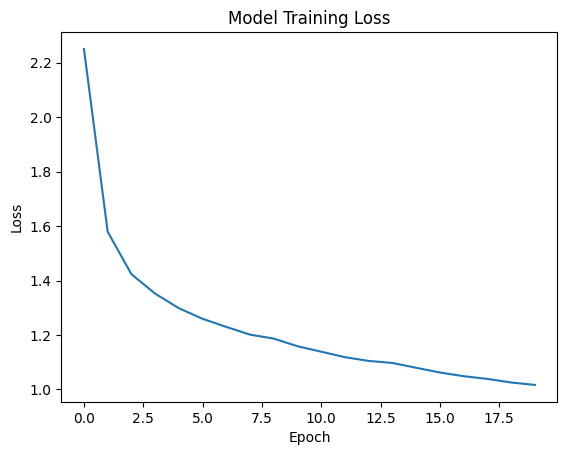

In [37]:
from keras.utils import to_categorical

epochs = 20
batch_size = 10  

y_train_encoded = to_categorical(y_train - 1, num_classes=total_unique_characters)

history = model.fit(X_train_normalized, y_train_encoded, epochs=epochs, batch_size=batch_size, verbose=1)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

If it does not overfit try to fix data prep and model architecture so it does

In [19]:
print(history.history)

{'loss': [2.231734275817871, 1.559977412223816, 1.414832592010498, 1.3370838165283203, 1.2859724760055542, 1.2499719858169556, 1.2216739654541016, 1.1982399225234985, 1.178557276725769, 1.1545640230178833, 1.136260986328125, 1.1275602579116821, 1.107238531112671, 1.0933979749679565, 1.0797613859176636, 1.0669487714767456, 1.0534534454345703, 1.0412770509719849, 1.0316143035888672, 1.0160223245620728], 'accuracy': [0.32078802585601807, 0.5089123249053955, 0.5463274717330933, 0.5677390694618225, 0.5783069133758545, 0.5892610549926758, 0.5976491570472717, 0.6010153889656067, 0.6068097949028015, 0.6111142039299011, 0.6199437379837036, 0.6219855546951294, 0.6264830827713013, 0.6313117146492004, 0.633160412311554, 0.6381546258926392, 0.6427625417709351, 0.6432592272758484, 0.6493018865585327, 0.6525577902793884]}


Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [1]:
import numpy as np

def make_prediction(seed_start, model, char_mapper, max_length):
    generated_molecule = seed_start

    while len(generated_molecule) < max_length:
        seed_encoded = char_mapper.map_char_to_int(generated_molecule)

        # Assurez-vous que seed_encoded est une liste de longueur variable

        seed_input = np.array([seed_encoded])  # Remodeler en (1, max_length)
        predicted_probs = model.predict(seed_input)[0]
        next_char_index = np.argmax(predicted_probs)

        next_char = char_mapper.map_int_to_char(next_char_index)

        generated_molecule += next_char

        if next_char == '\n':
            break

    return generated_molecule

generate a molecule of your overfitted model

In [2]:
seed_start = "CC"

generated_molecule = make_prediction(seed_start, model,char_mapper, max_length=100)

print("Generated Molecule:")
print(generated_molecule)


NameError: name 'model' is not defined

Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better